✅ Data loaded: (429435, 67)
36810
9203

Training with OscillatingLR
OscillatingLR | Epoch [5/20] | Loss: 0.99991
OscillatingLR | Epoch [10/20] | Loss: 0.94017
OscillatingLR | Epoch [15/20] | Loss: 0.84742
OscillatingLR | Epoch [20/20] | Loss: 0.77181

Training with SGD
SGD | Epoch [5/20] | Loss: 1.04516
SGD | Epoch [10/20] | Loss: 0.93295
SGD | Epoch [15/20] | Loss: 0.82674
SGD | Epoch [20/20] | Loss: 0.73097

Training with Adam
Adam | Epoch [5/20] | Loss: 0.72297
Adam | Epoch [10/20] | Loss: 0.68509
Adam | Epoch [15/20] | Loss: 0.61320
Adam | Epoch [20/20] | Loss: 0.57377

Training with RMSprop
RMSprop | Epoch [5/20] | Loss: 0.92454
RMSprop | Epoch [10/20] | Loss: 0.75320
RMSprop | Epoch [15/20] | Loss: 0.64617
RMSprop | Epoch [20/20] | Loss: 0.62220


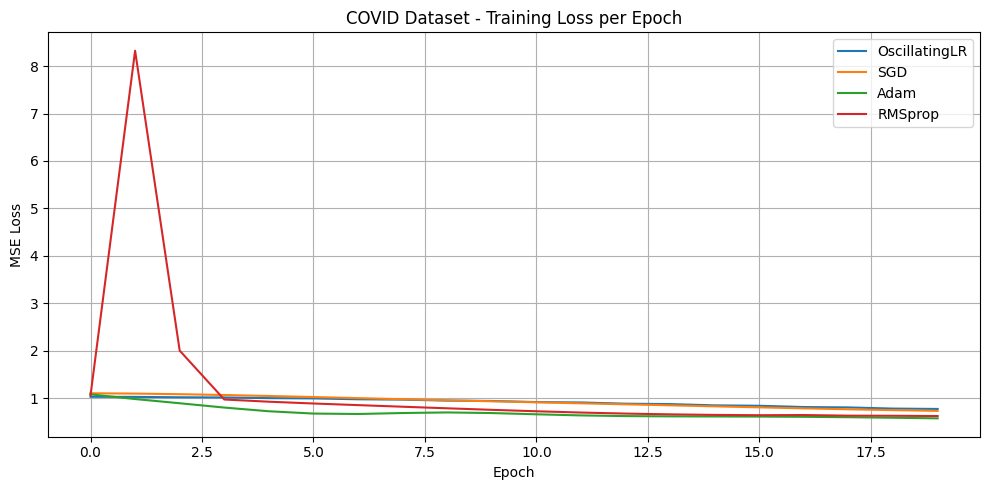


✅ Final RMSE comparison:
       Optimizer     Test RMSE
0  OscillatingLR  68489.347306
1            SGD  67064.644428
2           Adam  60007.952222
3        RMSprop  62698.308382


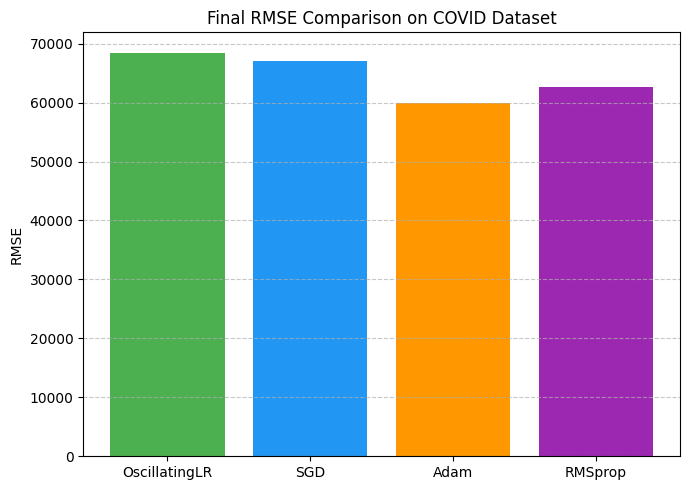

In [1]:
# =====================================================
# OscillatingLR vs SGD vs Adam vs RMSprop on COVID dataset
# =====================================================

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import requests, io

# ----------------------------
# 1. Reproducibility
# ----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
set_seed(42)

# ----------------------------
# 2. Custom OscillatingLR Optimizer
# ----------------------------
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=0.01, oscillation_factor=0.005, momentum=0.9):
        self.base_lr = base_lr
        self.oscillation_factor = oscillation_factor
        self.momentum = momentum
        self.step_count = 0
        defaults = dict(momentum=momentum)
        super(OscillatingLR, self).__init__(params, defaults)
        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param)}

    def step(self, closure=None):
        self.step_count += 1
        if self.step_count % 2 == 0:
            lr = self.base_lr + self.oscillation_factor
        else:
            lr = self.base_lr - self.oscillation_factor

        for group in self.param_groups:
            momentum = group['momentum']
            for param in group['params']:
                if param.grad is not None:
                    velocity = self.state[param]['velocity']
                    velocity.mul_(momentum).add_(param.grad)
                    param.data -= lr * velocity
                    self.state[param]['velocity'] = velocity
        if closure is not None:
            return closure()
        return lr

# ----------------------------
# 3. Load COVID dataset (Our World in Data)
# ----------------------------
url = "https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv"
print("Downloading dataset...")
df = pd.read_csv(url)
print("✅ Data loaded:", df.shape)

# Keep only relevant numeric columns
numeric_cols = [
    'new_cases', 'new_deaths', 'reproduction_rate', 'people_vaccinated',
    'population_density', 'median_age', 'gdp_per_capita', 'stringency_index'
]
df = df[numeric_cols].dropna().reset_index(drop=True)

# Define input/output
X = df.drop('new_cases', axis=1).values
y = df['new_cases'].values.reshape(-1, 1)

# Standardize
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(X_test))
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# ----------------------------
# 4. Simple MLP model
# ----------------------------
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# ----------------------------
# 5. Train and evaluate function
# ----------------------------
def train_and_evaluate(optimizer_name, optimizer_class, **optimizer_params):
    model = MLP(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    num_epochs = 20
    losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 5 == 0:
            print(f"{optimizer_name} | Epoch [{epoch+1}/{num_epochs}] | Loss: {loss.item():.5f}")

    # Evaluate
    model.eval()
    with torch.no_grad():
        preds = model(X_test)
        rmse = np.sqrt(mean_squared_error(
            scaler_y.inverse_transform(y_test),
            scaler_y.inverse_transform(preds.numpy())
        ))

    return losses, rmse

# ----------------------------
# 6. Run comparisons
# ----------------------------
optimizers = {
    "OscillatingLR": (OscillatingLR, {"base_lr": 0.01, "oscillation_factor": 0.005, "momentum": 0.9}),
    "SGD": (optim.SGD, {"lr": 0.01, "momentum": 0.9}),
    "Adam": (optim.Adam, {"lr": 0.01}),
    "RMSprop": (optim.RMSprop, {"lr": 0.01}),
}

results = {}
rmses = {}

for name, (opt_class, opt_params) in optimizers.items():
    print("\n" + "="*60)
    print(f"Training with {name}")
    losses, rmse = train_and_evaluate(name, opt_class, **opt_params)
    results[name] = losses
    rmses[name] = rmse

# ----------------------------
# 7. Visualize results
# ----------------------------
plt.figure(figsize=(10,5))
for name, losses in results.items():
    plt.plot(losses, label=name)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("COVID Dataset - Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("covid_loss_comparison.png")
plt.show()

# Final RMSE comparison
rmse_df = pd.DataFrame(list(rmses.items()), columns=["Optimizer", "Test RMSE"])
print("\n✅ Final RMSE comparison:")
print(rmse_df)

plt.figure(figsize=(7,5))
plt.bar(rmse_df["Optimizer"], rmse_df["Test RMSE"], color=["#4CAF50","#2196F3","#FF9800","#9C27B0"])
plt.title("Final RMSE Comparison on COVID Dataset")
plt.ylabel("RMSE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("covid_rmse_comparison.png")
plt.show()
